<a href="https://colab.research.google.com/github/ananyabanka/22BDS0154/blob/main/AirCanvas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AirCanvas - Ananya Banka (22BDS0154)

In [1]:
#Install all libraries

In [2]:
!pip install mediapipe opencv-python numpy pillow tensorflow-cpu matplotlib scikit-learn onnxruntime tf2onnx


In [3]:
#Mount Google Drive & create project folders

In [4]:
from google.colab import drive
import os

drive.mount('/content/drive')

project_dir = '/content/drive/MyDrive/AirCanvas_Project'
for f in ['data','airdraw_data','models','checkpoints','logs']:
    os.makedirs(os.path.join(project_dir,f), exist_ok=True)
print("Drive mounted & folders ready:", project_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted & folders ready: /content/drive/MyDrive/AirCanvas_Project


In [5]:
#Download QuickDraw data for pretraining

In [6]:
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/star.npy -O star.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/circle.npy -O circle.npy


--2025-11-11 15:36:32--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/star.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 192.178.163.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107893376 (103M) [application/octet-stream]
Saving to: ‘star.npy’

star.npy            100%[===================>] 102.89M   217MB/s    in 0.5s    

2025-11-11 15:36:32 (217 MB/s) - ‘star.npy’ saved [107893376/107893376]

--2025-11-11 15:36:32--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/circle.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 192.178.163.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96334864 (92M) [application/octet-stream]
Sav

In [7]:
#Convert QuickDraw NPY data into PNG images

In [8]:
import numpy as np, cv2, os

classes = ['star','circle']
for cls in classes:
    os.makedirs(f"{project_dir}/data/{cls}", exist_ok=True)
    data = np.load(f"{cls}.npy").reshape(-1,28,28)
    for i,img in enumerate(data[:1500]):     # first 1500 samples/class
        img = cv2.resize(img, (128,128))
        cv2.imwrite(f"{project_dir}/data/{cls}/{i}.png", img)
print("✅ QuickDraw dataset prepared successfully!")


✅ QuickDraw dataset prepared successfully!


In [9]:
#Data Generators for QuickDraw Pretraining

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE=(128,128)
BATCH_SIZE=32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    f"{project_dir}/data", target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training')

val_gen = datagen.flow_from_directory(
    f"{project_dir}/data", target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation')


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [11]:
#Build CNN Model

In [12]:
from tensorflow.keras import layers, models

def build_model(num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(len(train_gen.class_indices))
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,578 (28.20 MB)

 Trainable params: 7,392,578 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#Pretrain on QuickDraw with auto-checkpoint

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

q_ckpt = os.path.join(project_dir,'checkpoints','quickdraw_best.h5')
checkpoint = ModelCheckpoint(q_ckpt, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history_q = model.fit(train_gen, validation_data=val_gen, epochs=10,
                      callbacks=[checkpoint, early_stop])

model.save(os.path.join(project_dir,'models','quickdraw_base.h5'))


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.9193 - loss: 0.1609
Epoch 1: val_accuracy improved from -inf to 0.98333, saving model to /content/drive/MyDrive/AirCanvas_Project/checkpoints/quickdraw_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 770ms/step - accuracy: 0.9199 - loss: 0.1602 - val_accuracy: 0.9833 - val_loss: 0.0424
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9833 - loss: 0.0408
Epoch 2: val_accuracy improved from 0.98333 to 0.98667, saving model to /content/drive/MyDrive/AirCanvas_Project/checkpoints/quickdraw_best.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 766ms/step - accuracy: 0.9833 - loss: 0.0406 - val_accuracy: 0.9867 - val_loss: 0.0557
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9937 - loss: 0.0164
Epoch 3: val_accuracy did not improve from 0.98667
75/75 ━━━━━━━━━━━━━━━━━━━━ 56s 741ms/step - accuracy: 0.9937 - loss: 0.0164 - val_accuracy: 0.9817 - val_loss: 0.0551
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.9996 - loss: 0.0053
Epoch 4: val_accuracy did not improve from 0.98667
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 716ms/step - accuracy: 0.9996 - loss: 0.0053 - val_accuracy: 0.9833 - val_loss: 0.0747
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9913 - loss: 0.0299
Epoch 5: val_accuracy did not improve from 0.98667
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 713ms/step - accuracy: 0.9913 - loss: 0.0298 - val_accuracy: 0.9817 - val_loss: 0.0657


In [15]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!ls "/content/drive/MyDrive/AirCanvas_Project/"


airdraw_data  checkpoints  data  logs  models


In [17]:
!ls "/content/drive/MyDrive/AirCanvas_Project/airdraw_data"


butterfly  cloud   heart  mountain  square  sun
circle	   flower  house  smiley    star    tree


In [18]:
# Sequential-compatible fine-tuning for 12 classes
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

project_dir = '/content/drive/MyDrive/AirCanvas_Project'
IMG_SIZE = (128,128)

# --- Data Generators ---
datagen_ft = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_air = datagen_ft.flow_from_directory(
    f"{project_dir}/airdraw_data", target_size=IMG_SIZE, batch_size=16,
    class_mode='categorical', subset='training')
val_air = datagen_ft.flow_from_directory(
    f"{project_dir}/airdraw_data", target_size=IMG_SIZE, batch_size=16,
    class_mode='categorical', subset='validation')

num_classes = len(train_air.class_indices)
print(f"Detected {num_classes} output classes.")

# --- Load pretrained model ---
base_model = load_model(os.path.join(project_dir, 'models', 'quickdraw_base.h5'))

# --- Rebuild as Sequential ---
model = Sequential()
for layer in base_model.layers[:-1]:  # take all layers except old Dense head
    layer.trainable = False           # freeze pretrained layers
    model.add(layer)

# --- Add new classification layer for your 12 classes ---
model.add(Dense(num_classes, activation='softmax'))

# --- Compile ---
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Callbacks ---
ft_ckpt = os.path.join(project_dir, 'checkpoints', 'airdraw_best.h5')
ft_checkpoint = ModelCheckpoint(ft_ckpt, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Fine-tune ---
history_ft = model.fit(train_air, validation_data=val_air, epochs=15, callbacks=[ft_checkpoint, early_stop])
model.save(os.path.join(project_dir, 'models', 'airdraw_final.h5'))

print("Fine-tuned model saved successfully.")


Found 263 images belonging to 12 classes.
Found 61 images belonging to 12 classes.
Detected 12 output classes.


Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1782 - loss: 2.7424
Epoch 1: val_accuracy improved from -inf to 0.13115, saving model to /content/drive/MyDrive/AirCanvas_Project/checkpoints/airdraw_best.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 118s 7s/step - accuracy: 0.1755 - loss: 2.7432 - val_accuracy: 0.1311 - val_loss: 2.6044
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.1032 - loss: 2.5863
Epoch 2: val_accuracy did not improve from 0.13115
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.1046 - loss: 2.5827 - val_accuracy: 0.1311 - val_loss: 2.4566
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.1304 - loss: 2.4262
Epoch 3: val_accuracy did not improve from 0.13115
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.1303 - loss: 2.4261 - val_accuracy: 0.1311 - val_loss: 2.3984
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.1391 - loss: 2.3883
Epoch 4: val_accuracy improved from 0.13115 to 0.18033, saving model to /content/drive/MyDrive/AirCanvas_Project/checkpoints/airdraw_best.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.1398 - loss: 2.3882 - val_accuracy: 0.1803 - val_loss: 2.3744
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.1641 - loss: 2.3756
Epoch 5: val_accuracy did not improve from 0.18033
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 294ms/step - accuracy: 0.1666 - loss: 2.3749 - val_accuracy: 0.1639 - val_loss: 2.3611
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2473 - loss: 2.3246
Epoch 6: val_accuracy did not improve from 0.18033
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.2460 - loss: 2.3260 - val_accuracy: 0.1803 - val_loss: 2.3486
Epoch 7/15
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.1914 - loss: 2.3506
Epoch 7: val_accuracy did not improve from 0.18033
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.1951 - loss: 2.3488 - val_accuracy: 0.1803 - val_loss: 2.3387
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.1792 - loss: 2.3182
Epoch 8: val_accuracy did not impro

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.2534 - loss: 2.2466 - val_accuracy: 0.1967 - val_loss: 2.2797
Epoch 15/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2315 - loss: 2.2357
Epoch 15: val_accuracy did not improve from 0.19672
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.2306 - loss: 2.2366 - val_accuracy: 0.1803 - val_loss: 2.2732


Fine-tuned model saved successfully.


In [19]:
datagen_ft = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)


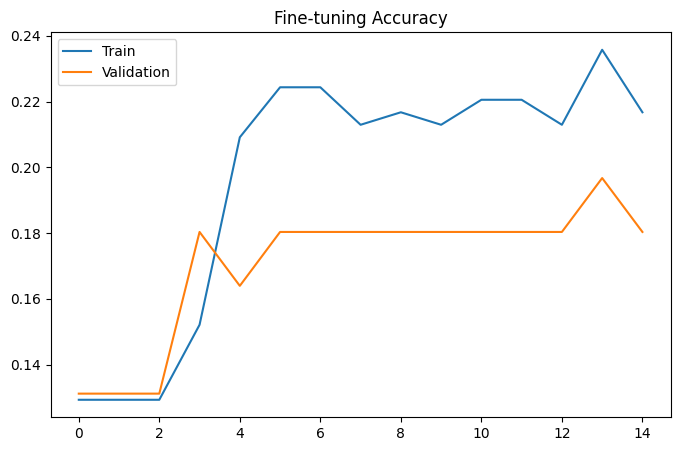

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(history_ft.history['accuracy'], label='Train')
plt.plot(history_ft.history['val_accuracy'], label='Validation')
plt.legend(); plt.title('Fine-tuning Accuracy'); plt.show()


In [21]:
#Test live AirCanvas drawings

In [22]:
from tensorflow.keras.models import load_model
import numpy as np, cv2

model = load_model(f"{project_dir}/models/airdraw_final.h5")
class_names = list(train_air.class_indices.keys())

def preprocess_aircanvas_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    inv = cv2.bitwise_not(gray)
    resized = cv2.resize(inv,(128,128))
    norm = resized / 255.0
    return np.expand_dims(norm, axis=(0,-1))

def predict_symbol(canvas):
    input_img = preprocess_aircanvas_image(canvas)
    pred = model.predict(input_img)
    idx = np.argmax(pred)
    return class_names[idx], pred[0][idx]


In [23]:
#AirCanvas Prediction

In [24]:
import numpy as np
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

project_dir = '/content/drive/MyDrive/AirCanvas_Project'
model_path = os.path.join(project_dir, 'models', 'airdraw_final.h5')
IMG_SIZE = (128,128)

# Load model & compile
model = load_model(model_path)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Emoji mapping
class_emojis = {
    'butterfly': '🦋',
    'circle': '⭕',
    'cloud': '☁️',
    'flower': '🌸',
    'heart': '❤️',
    'house': '🏠',
    'mountain': '⛰️',
    'smiley': '😊',
    'square': '⬜',
    'star': '⭐',
    'sun': '🌞',
    'tree': '🌳'
}

# Choose any test image
sample_path = os.path.join(project_dir, 'airdraw_data', 'star',
                           os.listdir(os.path.join(project_dir, 'airdraw_data', 'star'))[0])

# ✅ FIXED: Keep RGB input (3 channels)
def preprocess_aircanvas_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img, IMG_SIZE)
    norm = resized / 255.0
    return np.expand_dims(norm, axis=0)  # (1,128,128,3)

# Predict
img_input = preprocess_aircanvas_image(sample_path)
pred = model.predict(img_input)
idx = np.argmax(pred)
labels = list(class_emojis.keys())
pred_label = labels[idx]
confidence = pred[0][idx] * 100
emoji = class_emojis.get(pred_label, '🎨')

print(f"Predicted: {emoji} {pred_label} ({confidence:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted: ☁️ cloud (13.31%)


In [25]:
model.save('/content/drive/MyDrive/AirCanvas_Project/models/airdraw_final.h5')


In [26]:
final_h5 = r"C:\Users\Ananya Banka\AirCanvas_Project\models\airdraw_final.h5"
onnx_path = r"C:\Users\Ananya Banka\AirCanvas_Project\models\airdraw_final.onnx"


In [27]:
# Save your trained model as .h5 file
model.save('final_model.h5')

print("✅ Model saved successfully as 'final_model.h5'")


✅ Model saved successfully as 'final_model.h5'


In [28]:
!ls -lh


total 224M
-rw-r--r-- 1 root root  92M May 18  2017 circle.npy
drwx------ 5 root root 4.0K Nov 11 15:36 drive
-rw-r--r-- 1 root root  29M Nov 11 16:01 final_model.h5
drwxr-xr-x 1 root root 4.0K Nov  7 14:30 sample_data
-rw-r--r-- 1 root root 103M May 18  2017 star.npy


In [30]:
import os
os.makedirs("models", exist_ok=True)
model.save("models/final_model.h5")
print("✅ Model saved to /content/models/final_model.h5")


✅ Model saved to /content/models/final_model.h5


In [31]:
!ls -lh models/


total 29M
-rw-r--r-- 1 root root 29M Nov 11 16:03 final_model.h5


In [32]:
import os
MODEL_PATH = os.path.abspath("models/final_model.h5")  # or just "final_model.h5"
print("📂 Model file path:", MODEL_PATH)
print("🧾 File exists:", os.path.exists(MODEL_PATH))


📂 Model file path: /content/models/final_model.h5
🧾 File exists: True


In [33]:
from google.colab import files
files.download('final_model.h5')  # or 'models/final_model.h5'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
from tensorflow.keras.models import load_model
model = load_model('final_model.h5')  # or 'models/final_model.h5'
print("✅ Model loaded successfully.")


✅ Model loaded successfully.


In [37]:
# ✅ Evaluate model performance on test data
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"🧾 Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 375ms/step - accuracy: 0.3827 - loss: 2.1381

✅ Test Accuracy: 20.99%
🧾 Test Loss: 2.2484


In [36]:
# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255) # No augmentation for test data

test_gen = test_datagen.flow_from_directory(
    f"{project_dir}/airdraw_data",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Keep data in order for evaluation
)

print("✅ Test data generator created.")

Found 324 images belonging to 12 classes.
✅ Test data generator created.


In [38]:
import numpy as np

# ✅ Predict probabilities for each test image
y_pred_probs = model.predict(test_gen, verbose=1)

# ✅ Convert probabilities → predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# ✅ Get the true labels from generator
y_true = test_gen.classes

# ✅ Get the class label names
class_labels = list(test_gen.class_indices.keys())

print("Number of test samples:", len(y_true))
print("Number of predicted samples:", len(y_pred))
print("Class labels:", class_labels)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step
Number of test samples: 324
Number of predicted samples: 324
Class labels: ['butterfly', 'circle', 'cloud', 'flower', 'heart', 'house', 'mountain', 'smiley', 'square', 'star', 'sun', 'tree']


In [39]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=3))

# Optional individual metrics
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
weighted_precision = precision_score(y_true, y_pred, average='weighted')
weighted_recall = recall_score(y_true, y_pred, average='weighted')

print(f"\n✅ Weighted F1 Score: {weighted_f1:.3f}")
print(f"✅ Weighted Precision: {weighted_precision:.3f}")
print(f"✅ Weighted Recall: {weighted_recall:.3f}")


📊 Classification Report:

              precision    recall  f1-score   support

   butterfly      0.349     0.909     0.504        33
      circle      0.000     0.000     0.000        27
       cloud      0.145     0.762     0.244        42
      flower      0.000     0.000     0.000        32
       heart      0.000     0.000     0.000        31
       house      0.000     0.000     0.000        12
    mountain      0.000     0.000     0.000        11
      smiley      0.000     0.000     0.000        31
      square      0.000     0.000     0.000        31
        star      0.000     0.000     0.000        31
         sun      0.000     0.000     0.000        11
        tree      0.375     0.188     0.250        32

    accuracy                          0.210       324
   macro avg      0.072     0.155     0.083       324
weighted avg      0.091     0.210     0.108       324


✅ Weighted F1 Score: 0.108
✅ Weighted Precision: 0.091
✅ Weighted Recall: 0.210


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

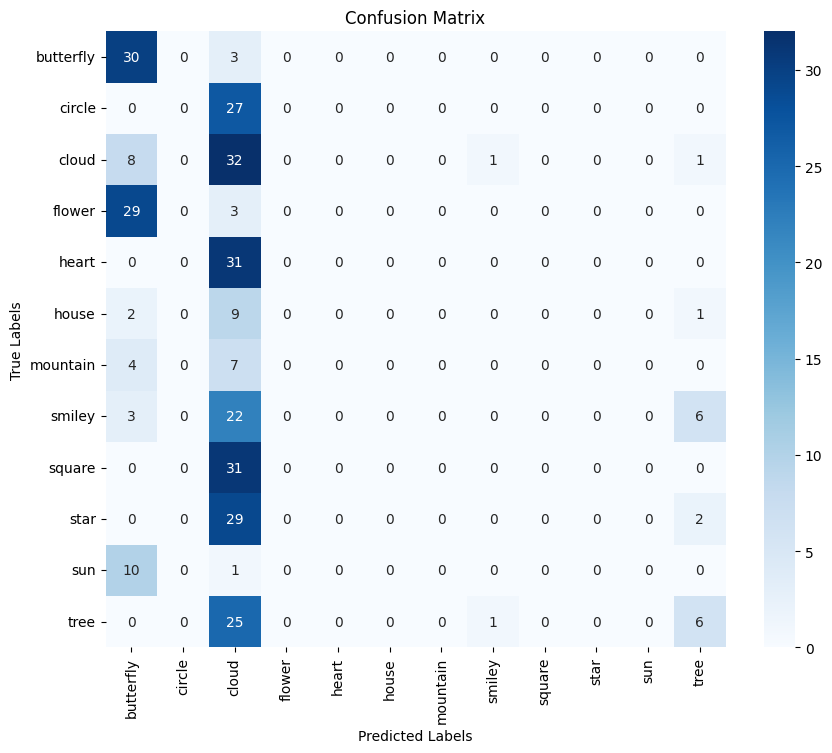

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


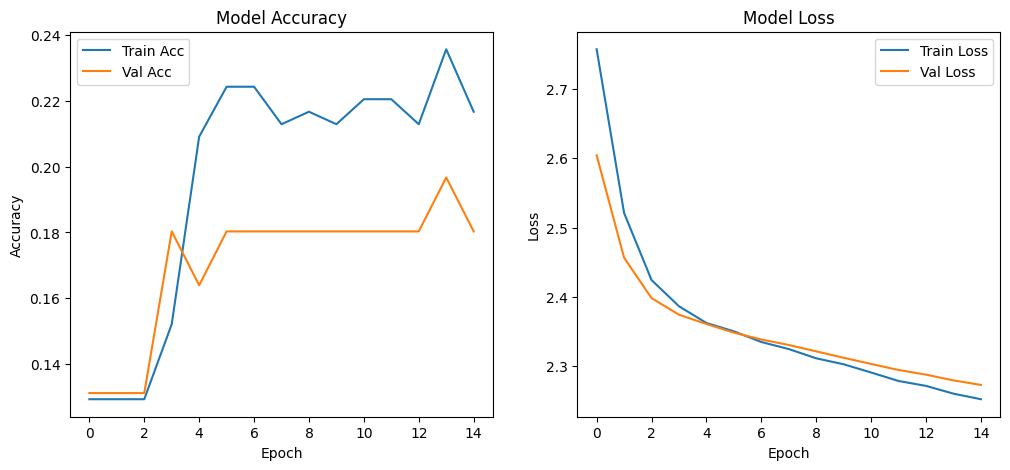

In [42]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_ft.history['accuracy'], label='Train Acc')
plt.plot(history_ft.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ft.history['loss'], label='Train Loss')
plt.plot(history_ft.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [43]:
# ✅ Save current model to file
model.save('final_model.h5')
print("✅ Model saved as final_model.h5 in current directory.")


✅ Model saved as final_model.h5 in current directory.


In [44]:
!ls -lh


total 224M
-rw-r--r-- 1 root root  92M May 18  2017 circle.npy
drwx------ 5 root root 4.0K Nov 11 15:36 drive
-rw-r--r-- 1 root root  29M Nov 11 16:15 final_model.h5
drwxr-xr-x 2 root root 4.0K Nov 11 16:03 models
drwxr-xr-x 1 root root 4.0K Nov  7 14:30 sample_data
-rw-r--r-- 1 root root 103M May 18  2017 star.npy


In [45]:
import os
MODEL_PATH = os.path.abspath("final_model.h5")
print("📂 Model file path:", MODEL_PATH)
print("🧾 File exists:", os.path.exists(MODEL_PATH))


📂 Model file path: /content/final_model.h5
🧾 File exists: True


In [46]:
from google.colab import files
files.download('/content/final_model.h5')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>